In [30]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import glob
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from timeit import default_timer as timer

In [59]:
# Hyperparameters
input_size = 150
batch_size = 32
num_conv_layers = 1  # 6
learning_rate = 0.001
epochs = 20  # 50

# 1. Dataset

## Exploring Dataset

In [3]:
DIR_TRAIN = "/content/drive/MyDrive/datasets/dataset1/train/"
DIR_TEST = "/content/drive/MyDrive/datasets/dataset1/test/"

In [4]:
classes = os.listdir(DIR_TRAIN)
print("total classes: ", len(classes))
train_imgs, test_imgs = [], []
image_formats = ['*.jpg', '*.jpeg', '*.png']

for _class in classes:
    for format in image_formats:
        train_imgs += glob.glob(os.path.join(DIR_TRAIN, _class, format))
        test_imgs += glob.glob(os.path.join(DIR_TEST, _class, format))

print("total train images: ", len(train_imgs))
print("total test images: ", len(test_imgs))

total classes:  2
total train images:  148
total test images:  43


## Loading dataset

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=1)], p=1),  # Flipped
    transforms.RandomApply([transforms.RandomRotation((90, 90))], p=1),  # 90-degree rotation
    transforms.RandomApply([transforms.RandomRotation((180, 180))], p=1),  # 180-degree rotation
    transforms.RandomApply([transforms.RandomRotation((270, 270))], p=1),  # 270-degree rotation
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [6]:
train_dataset = ImageFolder(root = DIR_TRAIN, transform = train_transforms)
test_dataset = ImageFolder(root = DIR_TEST, transform = test_transforms)

## Creating Dataloader

In [7]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=2
)

## Show a sample

In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 150, 150]), torch.Size([32]))

In [9]:
train_features_batch[0].shape, train_labels_batch[0].shape

(torch.Size([3, 150, 150]), torch.Size([]))

image size:  torch.Size([3, 150, 150])
label:  tensor(0)


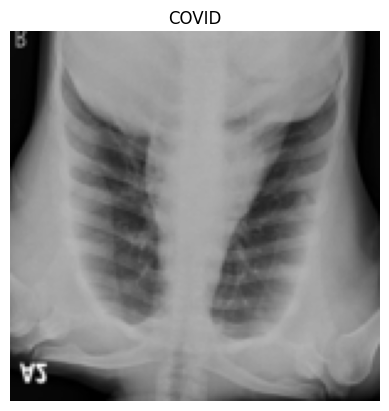

In [10]:
img, label = train_features_batch[0], train_labels_batch[0]
mean, std = 0.5, 0.5
img = img * std + mean
plt.imshow(img.permute(1, 2, 0))
plt.title(classes[label])
plt.axis('off')
print('image size: ', img.shape)
print('label: ', label)

# 2. Build CNN

In [11]:
# Define a CNN model with a variable number of convolutional layers
class COVIDClassifier(nn.Module):
    def __init__(self, num_layers):
        super(COVIDClassifier, self).__init__()
        channels = [3, 64, 64, 128, 128, 256, 256]
        self.conv_layers = nn.Sequential()

        for i in range(1, num_layers+1):
            self.conv_layers.add_module(f"conv_{i}", nn.Conv2d(channels[i-1], channels[i], kernel_size=3, padding=1))
            self.conv_layers.add_module(f"batchnorm_{i}", nn.BatchNorm2d(channels[i]))
            self.conv_layers.add_module(f"relu_{i}", nn.ReLU())
            self.conv_layers.add_module(f"maxpool_{i}", nn.MaxPool2d(kernel_size=2, stride=2))
            self.conv_layers.add_module(f"dropout_{i}", nn.Dropout(0.2))

        # Calculate output dimensions
        spatial_dim = input_size // (2 ** num_layers)
        num_features = spatial_dim ** 2 * channels[num_layers]

        # self.classifier = nn.Sequential()

        # Fully connected layers
        # self.classifier.add_module(f"flatten", nn.Flatten())
        # self.classifier.add_module(f"fc1", nn.Linear(num_features, 512))
        # self.classifier.add_module(f"bn1", nn.BatchNorm1d(512))
        # self.classifier.add_module(f"fc2", nn.Linear(512, 256))
        # self.classifier.add_module(f"bn2", nn.BatchNorm1d(256))
        # self.classifier.add_module(f"fc3", nn.Linear(256, 1))
        # # Sigmoid for binary classification
        # self.classifier.add_module(f"output_activation", nn.Sigmoid())


        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_features, 512)  # Adjust based on input size (150x150)     2*2
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 1)



        # Sigmoid for binary classification
        self.output_activation = nn.Sigmoid()

    def forward(self, x:torch.Tensor):
        x = self.conv_layers(x)
        # print('11111111111111111111111', x.shape)
        x = self.flatten(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        x = self.output_activation(x)
        return x

In [60]:
model = COVIDClassifier(num_layers=num_conv_layers)
model

COVIDClassifier(
  (conv_layers): Sequential(
    (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU()
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout_1): Dropout(p=0.2, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=360000, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (output_activation): Sigmoid()
)

In [34]:
summary(model, (3, 150, 150), device=device)

AttributeError: 'torch.device' object has no attribute 'lower'

In [35]:
random_sample = torch.randn((32, 3, 150, 150))
model(random_sample).shape

torch.Size([32, 1])

# 3. Training

In [18]:
# # FAKE
# def accuracy_fn(true, pred):
#     # Ensure true is of type torch.int64
#     true = true.to(torch.int64)
#     # Apply softmax to predictions
#     pred = F.softmax(pred, dim=1)
#     # Create one-hot encoding for true labels
#     true_one_hot = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
#     # Calculate accuracy
#     acc = (true_one_hot.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
#     acc = float((100 * acc.sum()) / len(acc))
#     return round(acc, 4)
#     # pred = F.softmax(pred, dim = 1)
#     # true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
#     # acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
#     # acc = float((100 * acc.sum()) / len(acc))
#     # return round(acc, 4)

In [36]:
def accuracy_fn(true, pred):
    # Since true labels are floats and might be used in a regression-like manner,
    # we'll treat them as binary labels (0 or 1) based on a threshold.
    # For binary classification, the model output is typically a probability.
    # Here, we assume that the model output is a probability (between 0 and 1).

    # Convert predictions to binary labels (0 or 1) based on a threshold (0.5)
    pred_binary = (pred > 0.5).float()

    # Calculate accuracy
    acc = (true == pred_binary).float().sum().item()

    return acc

In [20]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    model.to(device)
    # layerwise_acc = {}
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc=f" train") as train_tqdm:
        for images, labels in train_tqdm:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            # 1. Forward pass
            prediction = model(images)
            # 2. Calculate loss
            loss = loss_fn(prediction, labels)
            train_loss += loss
            train_acc += accuracy_fn(true=labels.cpu(), pred=prediction.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)
            # 3. Optimizer zero grad
            optimizer.zero_grad()
            # 4. Loss backward
            loss.backward()
            # 5. Optimizer step
            optimizer.step()
        # Calculate loss and accuracy per epoch
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        # layerwise_acc[num_layers] = train_acc
    return train_loss.item(), train_acc

In [21]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    model.to(device)
    model.eval()
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc=" test") as test_tqdm:
        for images, labels in test_tqdm:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            # 1. Forward pass
            test_prediction = model(images)
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_prediction, labels)
            test_acc += accuracy_fn(true=labels.cpu(), pred=test_prediction.cpu())
            counter += 1
            test_tqdm.set_postfix(test_acc=test_acc/counter, test_loss=test_loss.item()/counter, refresh=True)
        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)
    return test_loss.item(), test_acc

In [63]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda', index=0)

In [64]:
train_epoch_loss = []
train_epoch_accuracy = []
test_epoch_loss = []
test_epoch_accuracy = []

train_time_start = timer()

for epoch in range(epochs):
    print("Epoch {}/{} :".format(epoch +1, epochs))
    train_loss, train_acc = train_step(data_loader=train_dataloader,
                                              model=model,
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              accuracy_fn=accuracy_fn,
                                              device=device
                                              )
    test_loss, test_acc = test_step(data_loader=test_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device
                                    )
    train_epoch_loss.append(train_loss)
    train_epoch_accuracy.append(train_acc)
    test_epoch_loss.append(test_loss)
    test_epoch_accuracy.append(test_acc)

train_time_end = timer()
total_time = train_time_end - train_time_start
print(f"\n\nTrain time: {total_time:.3f} seconds")

Epoch 1/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, test_acc=15.5, test_loss=0.619]


Epoch 2/20 :


 test: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, test_acc=14.5, test_loss=0.653]


Epoch 3/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, test_acc=10, test_loss=3.06]


Epoch 4/20 :


 test: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, test_acc=16, test_loss=0.747]


Epoch 5/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, test_acc=12, test_loss=1.77]


Epoch 6/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, test_acc=17, test_loss=0.849]


Epoch 7/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s, test_acc=15, test_loss=1.05]


Epoch 8/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, test_acc=13, test_loss=1.62]


Epoch 9/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, test_acc=13, test_loss=1.75]


Epoch 10/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, test_acc=14, test_loss=1.7]


Epoch 11/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s, test_acc=14, test_loss=1.66]


Epoch 12/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, test_acc=14, test_loss=1.66]


Epoch 13/20 :


 test: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it, test_acc=14, test_loss=1.69]


Epoch 14/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, test_acc=14, test_loss=1.76]


Epoch 15/20 :


 test: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it, test_acc=14, test_loss=1.84]


Epoch 16/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, test_acc=13.5, test_loss=1.9]


Epoch 17/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s, test_acc=13, test_loss=1.94]


Epoch 18/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, test_acc=13, test_loss=3.28]


Epoch 19/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, test_acc=13, test_loss=3.29]


Epoch 20/20 :


 test: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, test_acc=13, test_loss=3.3]



Train time: 142.403 seconds


In [25]:
torch.save(model.state_dict(), 'saved_model')

# 4. Evaluation

In [26]:
def accloss_plots(train_loss=train_epoch_loss,
                  test_loss=test_epoch_loss,
                  train_acc=train_epoch_accuracy,
                  test_acc=test_epoch_accuracy):
    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.show();

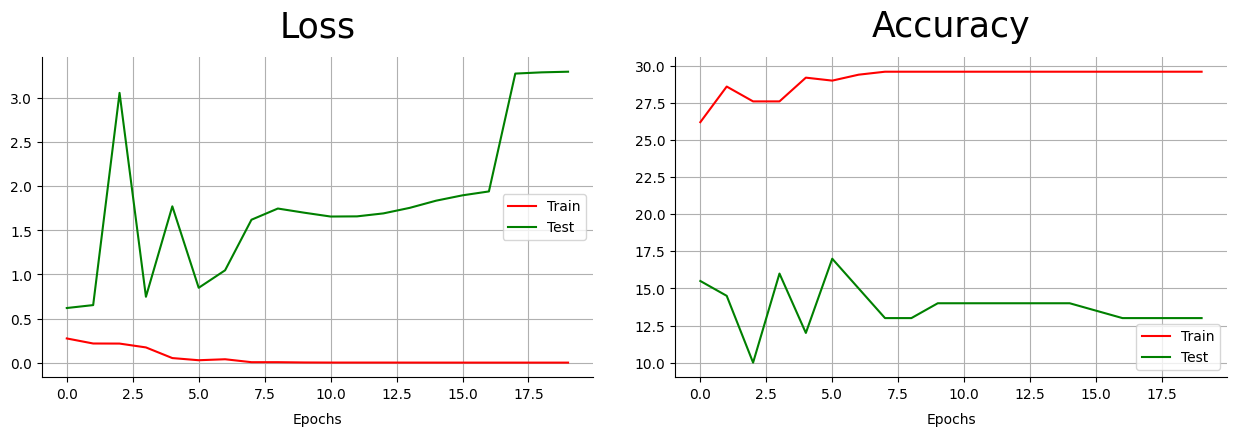

In [65]:
accloss_plots(train_loss=train_epoch_loss,
              test_loss=test_epoch_loss,
              train_acc=train_epoch_accuracy,
              test_acc=test_epoch_accuracy)

In [28]:
def evaluate_model(model, test_dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Reshape labels to match output shape
            outputs = model(images)  # Forward pass
            preds = (outputs > 0.5).float()  # Convert probabilities to binary labels (0 or 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)  # Sensitivity
    specificity = recall_score(all_labels, all_preds, pos_label=0)  # True Negative Rate
    f1 = f1_score(all_labels, all_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Accuracy: 0.6047
Precision: 0.5405
Sensitivity (Recall): 1.0000
Specificity: 0.2609
F1 Score: 0.7018


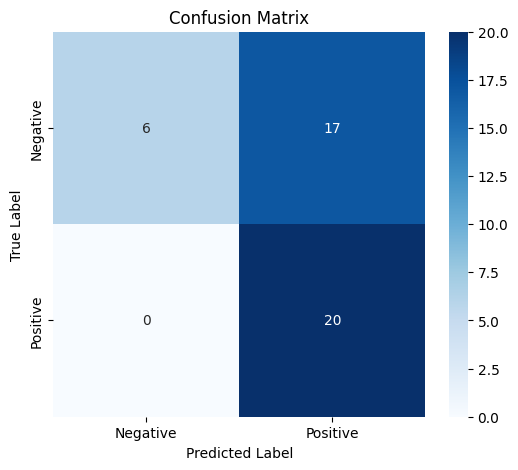

In [66]:
evaluate_model(model, test_dataloader, device)
